# Choose dataset to train / test on

In [91]:
# choose dataset from 'NPOV', 'WNC', 'CrowS-Pairs', 'Stereo', 'Mixed'
dataset = 'WNC'

# Installs

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 11.0 MB/s 
     |████████████████████████████████| 120 kB 55.1 MB/s 
     |████████████████████████████████| 6.6 MB 49.4 MB/s 


# Imports

In [4]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import sys
from transformers import BertTokenizer, BertModel 

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

# Set up

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Dataset

In [92]:
# import datasets
source_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Data/Processed Datasets/"
train_df = pd.read_csv(source_folder + dataset + '_train.csv', delimiter=',')
val_df = pd.read_csv(source_folder + dataset + '_valid.csv', delimiter=',')
test_df = pd.read_csv(source_folder + dataset + '_test.csv', delimiter=',')

In [93]:
target_list = ['label']

In [94]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [95]:
# hyperparameters
max_len = 200
train_batch_size = 32
val_batch_size = 32
test_batch_size = 32

In [96]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['text']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=False,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(), # ID of each token in the text
            'attention_mask': inputs['attention_mask'].flatten(),
            # 'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]) # Bias and Unbias label (0 when False, 1 when True)
        }

In [97]:
train_dataset = CustomDataset(train_df, tokenizer, max_len)
val_dataset = CustomDataset(val_df, tokenizer, max_len)
test_dataset = CustomDataset(test_df, tokenizer, max_len)

In [98]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(val_dataset, 
    batch_size=val_batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=test_batch_size,
    shuffle=True,
    num_workers=0
)

# Model checkpoint

In [14]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

# BERT model

In [15]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 1) # BERT output layer has dim. of 768, and we have 2 classes
    
    def forward(self, input_ids, attn_mask):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
        ) # contains 2 outputs: sequence and pooler output. --> we want the pooler output
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

# Choose trained model to load and use for testing

In [99]:
dataset = 'NPOV'

# Initialise loss, optimiser and model. Load model if needed.

In [17]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

model = BERTClass()
model.to(device)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=1e-5)

destination_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints"

try:
  load_checkpoint(destination_folder + '/bert_model_' + dataset + '.pt', model, optimizer) # comment this if you wannt to trainn the model from zero
  print('bert_model_' + dataset + '.pt --> loaded')
except:
  print('training bert_model_' + dataset + ' from scratch')

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/bert_model_Stereo.pt
bert_model_Stereo.pt --> loaded


# Training

In [ ]:
val_targets=[]
val_outputs=[]

In [ ]:
def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, destination_folder, best_valid_loss = np.Inf):
  
   
 
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        train_loss += loss.item()
    
    print('############# Epoch {}: Training End     #############'.format(epoch))

    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask)

            loss = loss_fn(outputs, targets)
            # valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            valid_loss += loss.item()
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= best_valid_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_valid_loss,valid_loss))
        # save checkpoint as best model
        save_checkpoint(destination_folder + '/bert_model_' + dataset + '.pt', model, optimizer, best_valid_loss)
        best_valid_loss = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [ ]:
epochs = 5
trained_model = train_model(epochs, train_loader, val_loader, model, optimizer, destination_folder)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.675384 	Average Validation Loss: 0.647083
Validation loss decreased (inf --> 0.647083).  Saving model ...
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/bert_model_Mixed.pt
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.612957 	Average Validation Loss: 0.644875
Validation loss decreased (0.647083 --> 0.644875).  Saving model ...
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/

# Testing

In [ ]:
# testing
corrects = 0
totals = 0

test_model = BERTClass()
test_model.to(device)
optimizer = torch.optim.Adam(params =  test_model.parameters(), lr=1e-5)
destination_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints"
load_checkpoint(destination_folder + '/bert_model_' + dataset + '.pt', test_model, optimizer)

with torch.no_grad():
  test_model.eval() 
  for batch_idx, data in enumerate(test_loader, 0): 
    input_ids = data['input_ids'].to(device, dtype=torch.long)
    attention_mask = data['attention_mask'].to(device, dtype=torch.long)
    # token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
    output = test_model(input_ids, attention_mask)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    pred_class = np.round(final_output)
    corrects += np.count_nonzero((data['targets'] - pred_class) == 0.)
    totals += len(pred_class)
  
  # Calculate accuracy of test set
  acc = corrects / totals

  print(f'accuracy = {acc * 100} %')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/bert_model_Mixed.pt
accuracy = 65.4 %


# Evaluation

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/bert_model_NPOV.pt
Classification Report:
remember: 1 = BIASED, 0 = UNBIASED
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         0
           0     1.0000    0.8522    0.9202     38515

    accuracy                         0.8522     38515
   macro avg     0.5000    0.4261    0.4601     38515
weighted avg     1.0000    0.8522    0.9202     38515



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


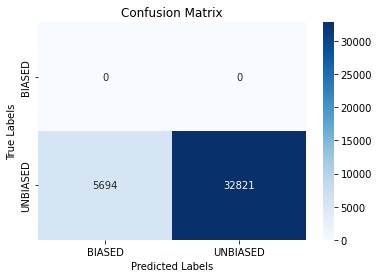

In [100]:
# Evaluation Function

def evaluate(model, test_loader, version='title'):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0): 
            input_ids = data['input_ids'].to(device, dtype=torch.long)
            attention_mask = data['attention_mask'].to(device, dtype=torch.long)
            output = model(input_ids, attention_mask)
            output = torch.sigmoid(output).cpu().detach().numpy().tolist()
            output = np.round(output)
            y_pred.extend(output.tolist())
            y_true.extend(data['targets'].tolist())
    
    print('Classification Report:')
    print('remember: 1 = BIASED, 0 = UNBIASED')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['BIASED', 'UNBIASED'])
    ax.yaxis.set_ticklabels(['BIASED', 'UNBIASED'])
    
    
best_model = BERTClass().to(device)
optimizer = torch.optim.Adam(params =  best_model.parameters(), lr=1e-5)

load_checkpoint(destination_folder + '/bert_model_' + dataset + '.pt', best_model, optimizer)
evaluate(best_model, test_loader)